In [1]:
from functools import reduce
import re
import string
import zipfile

import numpy as np
import scipy.sparse as sparse   
from scipy.sparse.linalg import svds
from scipy.sparse import find
from scipy.sparse import csr_matrix
from pandas import read_csv
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class StemmerWrapper:
    """ Class wrapper to some language stemmer; Via wrapping, I think,
        it is comfortable to operate with stemmer and functions,
        that formats text for systems.
    """
    def __init__(self, lang="russian"):
        """
        :param lang: Initializing stemmer with setting `lang` language
        """
        self.stemmer = SnowballStemmer(lang)

    def stem(self, *args, **kwargs):
        """ just for beauty and comfortable call"""
        return self.stemmer.stem(*args, **kwargs)

    @staticmethod
    def clean_string(sample_s: str) -> str:
        """
        :param sample_s: string to be formatted
        :return: formatted string
        formats given string by removing unnecessary components for
        building recommendation systems
        """
        # string to lowercase
        sample_s = sample_s.strip().lower()
        # removing one-symbol words
        sample_s = re.sub(r'\b[ЁёА-я]{1}\b', '', sample_s)
        # removing punctuation
        sample_s = re.sub(r'[%s]' % re.escape(string.punctuation), ' ',
                          sample_s)
        # removing one-digit numbers
        sample_s = re.sub(r'\b[0-9]{1}\b', '', sample_s)
        # replacing several-in-a-row space symbols with only one space
        sample_s = re.sub(r'\s+', ' ', sample_s)
        return sample_s.strip()


In [3]:
class Loader:
    """
    Class represents data-loader for systems. This is a base-class,
    so some virtual function must be overwritten.
    """
    def __init__(self, stemmer):
        """
        :param stemmer: language stemmer to be used
        """
        self.stemmer = stemmer

    def merge_contents(self,
                       table: str,
                       main_id: str,
                       content_cname: str,
                       columns: list):
        """
        merges content of selected `columns` from `table`;
        check overwritten function for more info.
        """
        pass

    @staticmethod
    def split_series(series):
        """
        :return: (pd.core.series.Series) updated `series`-copy
        :param series: (pd.core.series.Series)
        Splitting values in cell's of column `series` (in-place)
        """
        # handling None values separately
        return series.apply(lambda x: x.split() if type(x) == str else [])

    def format_columns(self,
                       dataframe,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param dataframe: contains data to be formatted and used
        :param main_id_cname: item-representing-column's name
        :param content_cname: content-representing-column's name
        :param columns: names of columns in dataframe
        :return: 2-column dataframe, named as main_id_cname and
            content_cname; second columns contains formatted
            and merged `columns` content
        """
        # initializing new column in dataframe with empty strings
        dataframe[content_cname] = ''

        # remember items-id-representing column
        id_series = dataframe[main_id_cname]

        # set dataframe to a `columns`-containing table,
        # where all string infos was split into lists
        dataframe = dataframe[[content_cname] + columns].apply(
                self.split_series)

        # formatting all rows
        # firstly, we put add all lists to content containing column
        dataframe[content_cname] = reduce(
                lambda prev, el: prev + dataframe[el],
                columns,
                dataframe[content_cname]
        ).apply(  # then we would stem all words in this column
                lambda iterable: [self.stemmer.stem(w) for w in iterable]
        ).apply(  # lastly, we join lists to string
                lambda iterable: ' '.join(iterable)
        ).apply(
                StemmerWrapper.clean_string
        )

        # set item-representing-column's data
        dataframe[main_id_cname] = id_series

        # return table representing relationship item
        return dataframe[[main_id_cname, content_cname]]

    def parse(self, table: str, columns: list):
        """
        parses selected `columns` from `table`;
        check overwritten function for more info.
        """
        pass


In [4]:
class CsvLoader(Loader):
    """
    Represents data-loader from csv-file
    """
    def __init__(self, stemmer):
        """
        :param stemmer: language stemmer to be used
        """
        super().__init__(stemmer)

    def merge_contents(self,
                       path: str,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param path: (str) path to table, where from data will be read
        :param main_id_cname: (str) item-representing-column's name;
            it is explicit for `path` to have such column
        :param content_cname: (str) content-representing-column's name
        :param columns: (list) columns containing main content,
            that will be used to build a content-based model
        :return: (pd.core.frame.DataFrame) 2-column dataframe
            representing relationship of item and it's content
            (one-to-one relationship)
        """
        return self.format_columns(
                self.parse(path, columns + [main_id_cname]),
                main_id_cname,
                content_cname,
                columns
        )

    def parse(self, table: str, columns: list):
        """
        :param table: database table name
        :param columns: columns to be parsed
        :return: dataframe with parsed columns
        """
        return read_csv(
                table,
                skipinitialspace=True,
                usecols=columns
        )


In [5]:
class RecommendationSystem:
    """
    Root-class representing recommendation system
    """
    def __init__(self):
        pass

    def load_and_build(self, *args):
        pass

    def load(self, *args):
        pass

    def build(self, *args):
        pass


In [6]:
class CollaborativeFiltering(RecommendationSystem):
    """
    Represents recommendation system based on collaborative-filtering
    """

    def __init__(self):
        super(CollaborativeFiltering, self).__init__()
        # sparse matrix of implicit user-item interactions
        self.sparse_matrix = None

        # dataframes, so we could map indices used in class
        # methods with indices used in database
        self.user_indices_decode = None
        self.item_indices_decode = None

        # column names in database corresponding to user and item
        self.user_cname = None
        self.item_cname = None

    def load(self,
             table: str,
             columns: list,
             loader_type: str = "csv",
             connection=None):
        """
        :param table: table name where from data will be read (this
            either table of database or path to csv file, depending
            on loader_typ)
        :param columns: 2 or 3 elements array - names of columns of
            user, item and their relationship coefficients (if it's
            provided)
        :param loader_type: equals either to "csv" or "db", depending
            on `table`
        :param connection: if loader_type equals to db, it must be
            connection to using database (otherwise - whatever)

        Loads data necessary to build model
        """
        # check for `columns` length
        if len(columns) < 2 or len(columns) > 3:
            raise RuntimeError("CollaborativeFiltering::load: columns "
                               "argument invalid format")

        # initialize loader
        if loader_type == "csv":
            loader = CsvLoader(None)
        elif loader_type == "db":
            if connection is None:
                raise RuntimeError("CollaborativeFiltering::load: received "
                                   "connection equals to None with a "
                                   "loader_type equals db")
            loader = DataBaseLoader(None, connection)
        else:
            raise RuntimeError("CollaborativeFiltering::load: no loader "
                               "available for given loader_type")

        # load implicit data in 3-column dataframe
        dataframe = loader.parse(table, columns)
        dataframe.dropna(inplace=True)

        relations_count = dataframe.shape[0]
        # copying column names explicitly
        self.user_cname, self.item_cname = columns[0] + "", columns[1] + ""
        user_id_cname, item_id_cname = columns[0] + "_id", columns[1] + "_id"

        # save user and item columns, so we will be able to return to
        # caller recommendation as it is stored in database
        dataframe[user_id_cname] = dataframe[columns[0]].astype(
                "category").cat.codes
        dataframe[item_id_cname] = dataframe[columns[1]].astype(
                "category").cat.codes
        self.user_indices_decode = dataframe[
            [user_id_cname, columns[0]]].drop_duplicates()
        self.item_indices_decode = dataframe[
            [item_id_cname, columns[1]]].drop_duplicates()
        dataframe.drop(columns[:2], axis=1, inplace=True)

        # initializing sparse matrix
        users = dataframe[user_id_cname].astype(int)
        items = dataframe[item_id_cname].astype(int)
        users_count = len(dataframe[user_id_cname].unique())
        items_count = len(dataframe[item_id_cname].unique())
        if len(columns) == 3:
            self.sparse_matrix = sparse.csr_matrix(
                    (dataframe[columns[2]], (users, items)),
                    shape=(users_count, items_count)
            )
        elif len(columns) == 2:
            self.sparse_matrix = sparse.csr_matrix(
                    ([1 for _ in range(relations_count)], (users, items)),
                    shape=(users_count, items_count)
            )

    def _item2index(self,
                    item):
        """
        :param item: item as it is stored in database
        :return: index used in this object for `item`
        """
        return self.item_indices_decode[
            self.item_cname + "_id"
            ].loc[self.item_indices_decode[self.item_cname] == item].iloc[0]

    def _user2index(self,
                    user):
        """
        :param user: user as it is stored in database
        :return: index used in this object for `user`
        """
        return self.user_indices_decode[
            self.user_cname + "_id"
            ].loc[self.user_indices_decode[self.user_cname] == user].iloc[0]

    def _index2item(self,
                    items_ids: list):
        """
        :param items_ids: list of indices as they are stored in this
            object
        :return: corresponding to `indices` values of items
        """
        result = list()
        for item_id in items_ids:
            result.append(
                    self.item_indices_decode[
                        self.item_cname
                    ].loc[
                        self.item_indices_decode[
                            self.item_cname + "_id"] == item_id
                        ].iloc[0]
            )
        return result


In [7]:
class ComplementItemRS(CollaborativeFiltering):
    """
    Class represents recommendation system, that recommends items,
    which are most suitable to some user based on experience of
    what other users like he liked/used.
    Actually, it can be used as complement items recommendation system,
    if user would be set to some `order`-type (so we will see what
    to recommend into user's shopping cart).
    """

    def __init__(self):
        super(ComplementItemRS, self).__init__()
        # items similarities matrix (items x items)
        self.similarities = None
        # items similarities matrix QR-decomposition matrices
        self.sim_q, self.sim_r = None, None
        # fast-recommendations matrix
        self.recommendations = None
        # use to save memory resources from lots of data possibly
        # never been recommended
        self.fast_reqs_limit = -1

    def set_limit(self, value: int = 100):
        """
        :param value: new value to be set
        """
        self.fast_reqs_limit = value

    def build(self,
              via_normalize: bool = False,
              big_data: bool = False):
        """
        :param via_normalize: set true if want to normalize items'
            vectors. They can be normalized for the situations, where
            opinion of man is more valuable if he has expressed it
            less compared to others (briefly, in binary data it must
            be nice).
        :param big_data: set true if want to multiply QR-decomposition
            for items' similarities matrix (only for big data's)
        """
        if via_normalize:
            self.sparse_matrix = self.sparse_matrix.astype(np.float32)
            # get l2-norm of rows
            magnitude = np.sqrt(self.sparse_matrix.power(2).sum(axis=1))

            # divide each row to it's l2-norm
            for i in range(magnitude.shape[0]):
                from_i = self.sparse_matrix.indptr[i]
                to_i = self.sparse_matrix.indptr[i + 1]
                self.sparse_matrix.data[from_i:to_i] = (
                        self.sparse_matrix.data[from_i:to_i] / magnitude[i][0]
                )
        # count cosine similarity matrix
        self.similarities = cosine_similarity(self.sparse_matrix.transpose())

        if big_data:
            self.sim_q, self.sim_r = np.linalg.qr(self.similarities)

            # counting how all users relates to all items
            self.recommendations = (self.sim_q @ (self.sim_r @ self.sparse_matrix.T))
        else:
            self.recommendations = (self.similarities @ self.sparse_matrix.T)
        # compared to max l1-norm of exact item's vector
        self.recommendations /= np.array([np.abs(self.similarities).sum(axis=1)]).T

        # remove from our answer set already liked by users items
        for user_id in range(self.sparse_matrix.shape[0]):
            for i in range(self.sparse_matrix.indptr[user_id],
                           self.sparse_matrix.indptr[user_id + 1]):
                self.recommendations[self.sparse_matrix.indices[i], user_id] = 0
        self.recommendations = np.argsort(-self.recommendations.T, axis=1)[:, :self.fast_reqs_limit]

    def find_similar_item(self,
                          item,
                          res_n: int = 10):
        """
        :param item: item as it is stored in database
            (meant it is in column that was given to load)
        :param res_n: count of items to find
        :return: `res_n` most similar to `item` items
        """
        item_id = self._item2index(item)
        # get vector corresponding to item
        item_vec = self.similarities[item_id].reshape(1, -1)[0]
        # choose top `res_n` and return them
        return self._index2item(np.argsort(item_vec)[::-1][1:res_n + 1])

    def recommend_to_user(self,
                          user,
                          res_n: int = 10):
        """
        :param user: user as it is stored in database
            (meant it is in column that was given to load)
        :param res_n: count of items to recommend
        :return: `res_n` most suitable (by RS) items for `user`
        """
        user_id = self._user2index(user)

        # counting how our user relates to all items
        if self.sim_q is None:
            scores_vec = (self.similarities @ self.sparse_matrix[user_id, :].T)
        else:
            scores_vec = (self.sim_q @ (self.sim_r @ self.sparse_matrix[user_id, :].T))
        # compared to max l1-norm of exact item's vector
        scores_vec /= np.array([np.abs(self.similarities).sum(axis=1)]).T

        # remove from our answer set already liked by user items
        for i in range(self.sparse_matrix.indptr[user_id],
                       self.sparse_matrix.indptr[user_id + 1]):
            scores_vec[self.sparse_matrix.indices[i], 0] = 0

        # choose top `res_n` and return them
        return self._index2item(np.argsort(scores_vec.T)[0][::-1][:res_n])

    def fast_recommend(self,
                       user,
                       res_n: int = 10):
        """
        :param user: user as it is stored in database
            (meant it is in column that was given to load)
        :param res_n: count of items to recommend
        :return: `res_n` most suitable (by RS) items for `user`
        """
        user_id = self._user2index(user)
        rec_vector = self.recommendations[user_id, :]
        return self._index2item(rec_vector[:res_n])

    def drop_slow(self):
        """
        delete all heavy object attrs that are not used in
        fast_recommend method
        """
        del self.similarities
        del self.sim_r
        del self.sim_q
        del self.sparse_matrix


In [8]:
complement_items = ComplementItemRS()
complement_items.load("../small_data/lastfm2collab.csv", ["user_id", "item_id"])
complement_items.build(False, True)
n, m = complement_items.similarities.shape
print("shape:\t", n, 'x', m)


shape:	 285 x 285


In [9]:
print("similar items:\t", complement_items.find_similar_item("linkin park"))
print("recommend items:\t", complement_items.recommend_to_user(5985))
complement_items.drop_slow()
print("fast recommend items:\t", complement_items.fast_recommend(5985))


similar items:	 ['limp bizkit', 'billy talent', 'papa roach', 'evanescence', 'sum 41', 'bullet for my valentine', 'three days grace', 'red hot chili peppers', 'avril lavigne', 'rise against']
recommend items:	 ['joy division', 'david bowie', 'the smiths', 'the rolling stones', 'tom waits', 'elliott smith', 'eric clapton', 'the clash', 'belle and sebastian', 'yann tiersen']
fast recommend items:	 ['joy division', 'david bowie', 'the smiths', 'the rolling stones', 'tom waits', 'elliott smith', 'eric clapton', 'the clash', 'belle and sebastian', 'yann tiersen']


In [10]:
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

In [11]:
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


In [12]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

In [28]:
def recommend(sparse_matrix, pred_am, similarities):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array (n_movies x rank)
            
        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    recommendations = similarities.transpose() @ (similarities @ sparse_matrix.T)
    print(recommendations.shape, similarities.shape)
    return np.argsort(-recommendations.T, axis=1)[:, :pred_am]

In [30]:
def evaluate_model(A_test, pred_am, mat, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        print(f"bench num#{i}")
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, mat)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

In [32]:
def get_hit_rates(A_test, pred_ams, mat):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users 
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    """
    hit_idx = evaluate_model(A_test, max(pred_ams), mat)
    hit_rates = []
    for pred_am in pred_ams:
        hit_rates.append(sum(map(lambda x: int(x < pred_am), hit_idx)) / len(hit_idx))
    return hit_rates

In [26]:
rank = 10
_, _, VT_svd = svds(A_train[:1000, :], k=rank)
print("hitrates:\t", *get_hit_rates(A_test[:1000, :], [10], VT_svd))
print("hitrates:\t", *get_hit_rates(A_test[:1000, :], [10], VT_svd))
print("hitrates:\t", *get_hit_rates(A_test[:1000, :], [10], VT_svd))

bench num#0
(65133, 500) (10, 65133)
bench num#500
(65133, 465) (10, 65133)
hitrate:	 0.11088082901554404
bench num#0
(65133, 500) (10, 65133)
bench num#500
(65133, 465) (10, 65133)
hitrate:	 0.11295336787564766
bench num#0
(65133, 500) (10, 65133)
bench num#500
(65133, 465) (10, 65133)
hitrate:	 0.13471502590673576


In [43]:
def recommend_slow(sparse_matrix, pred_am, U, S, Vt):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array (n_movies x rank)
            
        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    recommendations = ((np.multiply(Vt.T, S)) @ ((U.T @ U) @ (np.array([S]).T * (Vt @ sparse_matrix.T))))
    return np.argsort(-recommendations.T, axis=1)[:, :pred_am]

In [31]:
def evaluate_model_slow(A_test, pred_am, U, S, Vt, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        print(f"bench num#{i}")
        # Build recomendations for a batch.
        recommendations = recommend_slow(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, U, S, Vt)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

In [33]:
def get_hit_rates_slow(A_test, pred_ams, U, S, Vt):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users 
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    """
    hit_idx = evaluate_model_slow(A_test, max(pred_ams), U, S, Vt)
    hit_rates = []
    for pred_am in pred_ams:
        hit_rates.append(sum(map(lambda x: int(x < pred_am), hit_idx)) / len(hit_idx))
    return hit_rates

In [46]:
rank = 10
U, S, Vt = svds(A_train[:1000, :], k=rank)
print("hitrates for 10/20/30:\t", *get_hit_rates_slow(A_test[:1000, :], [10, 20, 30], U, S, Vt))
print("hitrates for 10/20/30:\t", *get_hit_rates_slow(A_test[:1000, :], [10, 20, 30], U, S, Vt))
print("hitrates for 10/20/30:\t", *get_hit_rates_slow(A_test[:1000, :], [10, 20, 30], U, S, Vt))

bench num#0
(1000, 10) (10,) (10, 65133) (65133, 500)
bench num#500
(1000, 10) (10,) (10, 65133) (65133, 465)
hitrates for 10/20/30:	 0.08911917098445596 0.15751295336787566 0.19170984455958548
bench num#0
(1000, 10) (10,) (10, 65133) (65133, 500)
bench num#500
(1000, 10) (10,) (10, 65133) (65133, 465)
hitrates for 10/20/30:	 0.09015544041450778 0.1461139896373057 0.19792746113989637
bench num#0
(1000, 10) (10,) (10, 65133) (65133, 500)
bench num#500
(1000, 10) (10,) (10, 65133) (65133, 465)
hitrates for 10/20/30:	 0.11606217616580311 0.18652849740932642 0.23316062176165803


bench num#0
(5000, 5) (5,) (5, 65133) (65133, 500)
bench num#500
(5000, 5) (5,) (5, 65133) (65133, 500)
bench num#1000
(5000, 5) (5,) (5, 65133) (65133, 500)
bench num#1500
(5000, 5) (5,) (5, 65133) (65133, 500)
bench num#2000
(5000, 5) (5,) (5, 65133) (65133, 500)
bench num#2500
(5000, 5) (5,) (5, 65133) (65133, 416)
bench num#0
(65133, 500) (5, 65133)
bench num#500
(65133, 500) (5, 65133)
bench num#1000
(65133, 500) (5, 65133)
bench num#1500
(65133, 500) (5, 65133)
bench num#2000
(65133, 500) (5, 65133)
bench num#2500
(65133, 416) (5, 65133)
bench num#0
(5000, 25) (25,) (25, 65133) (65133, 500)
bench num#500
(5000, 25) (25,) (25, 65133) (65133, 500)
bench num#1000
(5000, 25) (25,) (25, 65133) (65133, 500)
bench num#1500
(5000, 25) (25,) (25, 65133) (65133, 500)
bench num#2000
(5000, 25) (25,) (25, 65133) (65133, 500)
bench num#2500
(5000, 25) (25,) (25, 65133) (65133, 416)
bench num#0
(65133, 500) (25, 65133)
bench num#500
(65133, 500) (25, 65133)
bench num#1000
(65133, 500) (25, 651

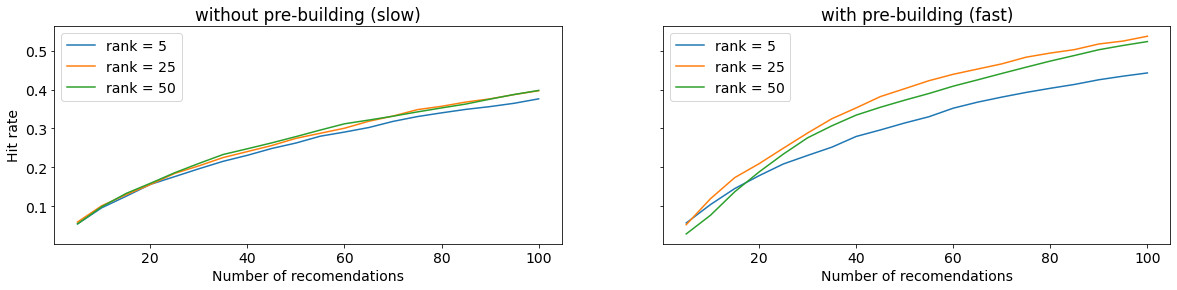

In [47]:
pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_slow, ax_fast) = plt.subplots(1,2,figsize=(20, 4),sharey=True)

ax_slow.set_ylabel("Hit rate")
ax_slow.set_title("without pre-building (slow)")
ax_fast.set_title("with pre-building (fast)")
for rank in [5, 25, 50]:
    U, S, VT = svds(A_train[:5000, :], k=rank)
    ax_slow.set_xlabel("Number of recomendations")
    hit_rates = get_hit_rates_slow(A_test[:3000,:], pred_ams, U, S, VT)
    line, = ax_slow.plot(pred_ams, hit_rates)
    line.set_label('rank = {}'.format(rank))
    ax_slow.legend()
    
    ax_fast.set_xlabel("Number of recomendations")
    hit_rates = get_hit_rates(A_test[:3000,:], pred_ams, VT)
    line, = ax_fast.plot(pred_ams, hit_rates)
    line.set_label('rank = {}'.format(rank))
    ax_fast.legend()
